# Install required packages

In [ ]:
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

# IMPORTS

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

PLOT STYLE AND DEVICE CHECK

In [ ]:
plt.style.use('bmh')
device_main = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used:", device_main)

Device used: cuda


# LOAD DATA

In [ ]:
dataset_ag = load_dataset("ag_news")
df_full = pd.concat([pd.DataFrame(dataset_ag['train']), pd.DataFrame(dataset_ag['test'])], ignore_index=True)
df_full = df_full.sample(frac=1, random_state=999).reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# SUBSAMPLE FOR FAST DEMO

In [ ]:
df_part, df_val = train_test_split(
    df_full, train_size=4000, test_size=1000,
    stratify=df_full['label'], random_state=101
)
category_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# LABELS BAR

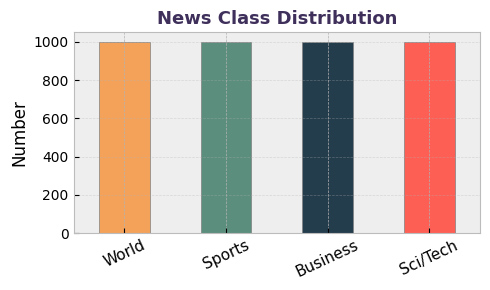

In [ ]:
plt.figure(figsize=(5,3))
colorset = ['#f4a259', '#5b8e7d', '#233d4d', '#fe5f55']
df_part['label'].value_counts().sort_index().plot(kind='bar', color=colorset, edgecolor='gray')
plt.xticks(range(4), category_names, rotation=25, fontsize=11)
plt.title('News Class Distribution', fontsize=13, fontweight='bold', color='#3e2f5b')
plt.xlabel('')
plt.ylabel('Number')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

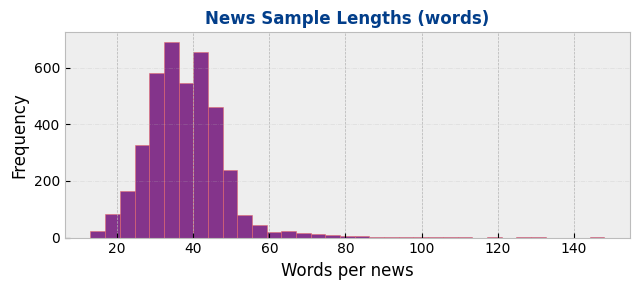

In [ ]:
# TEXT LENGTH HIST
df_part['text_count'] = df_part['text'].apply(lambda t: len(t.split()))
plt.figure(figsize=(6.5,3))
plt.hist(df_part['text_count'], bins=35, color='#6a0572', edgecolor='#e56b6f', alpha=0.8)
plt.title('News Sample Lengths (words)', fontsize=12, fontweight='bold', color='#023e8a')
plt.xlabel('Words per news')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-.', alpha=0.3)
plt.tight_layout()
plt.show()

# WORD CLOUDS

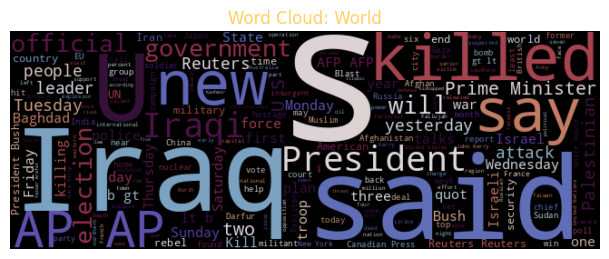

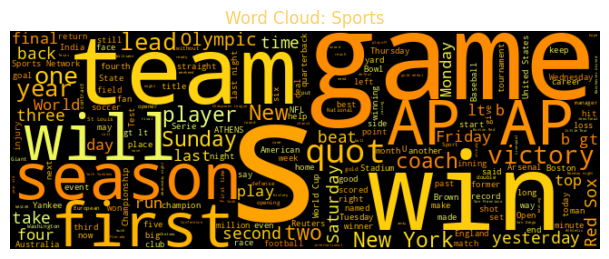

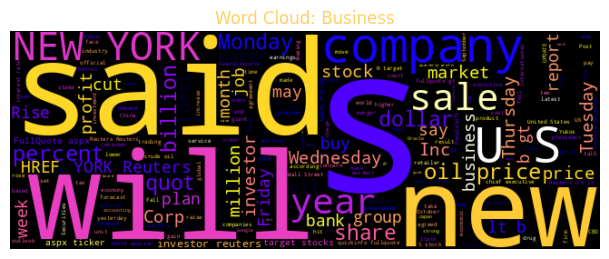

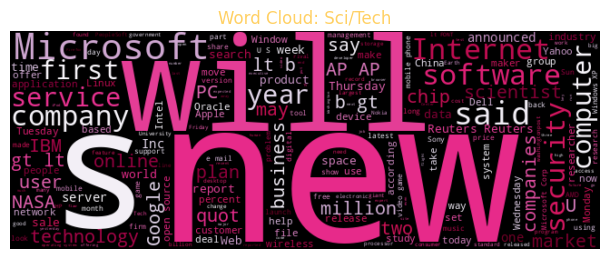

In [ ]:
cmap_list = ['twilight', 'Wistia', 'gnuplot2', 'PuRd']
for i, cname, cm in zip(range(4), category_names, cmap_list):
    wc_text = " ".join(df_part[df_part['label'] == i]['text'])
    wc_img = WordCloud(width=650, height=240, background_color='black', colormap=cm).generate(wc_text)
    plt.figure(figsize=(7.3,2.7))
    plt.imshow(wc_img, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {cname}', fontsize=12, color='#ffd166')
    plt.tight_layout()
    plt.show()

# MODEL DATA

In [ ]:
news_texts = df_part['text'].tolist()
news_targets = df_part['label'].tolist()
val_texts = df_val['text'].tolist()
val_targets = df_val['label'].tolist()

# CUSTOM DATASET CLASS

In [ ]:
class AGDataset(Dataset):
    def __init__(self, texts, classes, tok, mlen):
        self.texts = texts
        self.classes = classes
        self.tokenizer = tok
        self.maxlen = mlen
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.maxlen,
            return_tensors='pt'
        )
        data = {k: v.squeeze(0) for k, v in enc.items()}
        data['labels'] = torch.tensor(self.classes[idx], dtype=torch.long)
        return data

# TOKENIZER & DATALOADERS

In [ ]:
ag_token = BertTokenizer.from_pretrained('bert-base-uncased')
news_maxlen = 48
ag_trainset = AGDataset(news_texts, news_targets, ag_token, news_maxlen)
ag_valset = AGDataset(val_texts, val_targets, ag_token, news_maxlen)
train_batch = DataLoader(ag_trainset, batch_size=22, shuffle=True)
val_batch = DataLoader(ag_valset, batch_size=22)

# BERT SETUP

In [ ]:
news_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
news_bert = news_bert.to(device_main)
optimizer_bert = AdamW(news_bert.parameters(), lr=2e-5)
loss_bert = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# SAMPLE PREVIEW

In [ ]:
print("\nSample AG News data:\n")
for i in range(2):
    print(f"News: {val_texts[i][:110]}...")
    print(f"Label: {val_targets[i]} ({category_names[val_targets[i]]})\n")


Sample AG News data:

News: New Design for My Yahoo Adds Screen Real Estate New Design for My Yahoo Adds Screen Real Estate\\Yahoo is now ...
Label: 3 (Sci/Tech)

News: Sven:  #39;It #39;s three strikers or Wright-Phillips #39; Sven-Goran Eriksson says that he will select either...
Label: 1 (Sports)



# TRAIN

In [ ]:
epoch_count = 10
loss_hist = []

for ep in range(epoch_count):
    news_bert.train()
    ep_loss = 0
    for batch in train_batch:
        input_ids = batch['input_ids'].to(device_main)
        attn = batch['attention_mask'].to(device_main)
        labs = batch['labels'].to(device_main)
        optimizer_bert.zero_grad()
        outs = news_bert(input_ids=input_ids, attention_mask=attn, labels=labs)
        loss = outs.loss
        loss.backward()
        optimizer_bert.step()
        ep_loss += loss.item()
    avg_loss = ep_loss / len(train_batch)
    loss_hist.append(avg_loss)
    print(f"Epoch {ep+1}/{epoch_count} | Loss: {avg_loss:.4f}")

Epoch 1/10 | Loss: 0.5478
Epoch 2/10 | Loss: 0.2403
Epoch 3/10 | Loss: 0.1526
Epoch 4/10 | Loss: 0.0833
Epoch 5/10 | Loss: 0.0644
Epoch 6/10 | Loss: 0.0271
Epoch 7/10 | Loss: 0.0183
Epoch 8/10 | Loss: 0.0138
Epoch 9/10 | Loss: 0.0133
Epoch 10/10 | Loss: 0.0170


# LOSS GRAPH

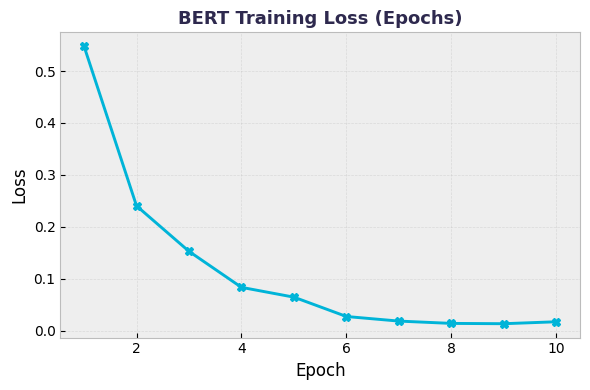

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epoch_count+1), loss_hist, marker='X', linestyle='-', color='#00b4d8', linewidth=2.1)
plt.title('BERT Training Loss (Epochs)', fontsize=13, fontweight='bold', color='#2e294e')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# EVALUATE


AG News Validation Accuracy: 0.9070
AG News Validation F1: 0.9066


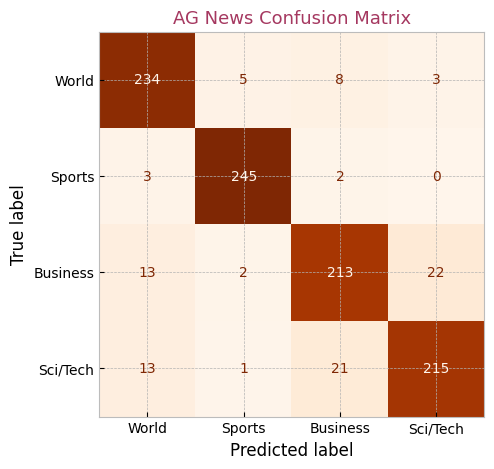

In [ ]:
news_bert.eval()
pred_labels = []
real_labels = []

with torch.no_grad():
    for batch in val_batch:
        input_ids = batch['input_ids'].to(device_main)
        attn = batch['attention_mask'].to(device_main)
        labs = batch['labels'].to(device_main)
        outputs = news_bert(input_ids=input_ids, attention_mask=attn)
        preds = torch.argmax(outputs.logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())
        real_labels.extend(labs.cpu().numpy())

news_acc = accuracy_score(real_labels, pred_labels)
news_f1 = f1_score(real_labels, pred_labels, average='weighted')
print(f"\nAG News Validation Accuracy: {news_acc:.4f}")
print(f"AG News Validation F1: {news_f1:.4f}")

cmatrix = confusion_matrix(real_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=category_names)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(cmap='Oranges', ax=ax, colorbar=False)
plt.title('AG News Confusion Matrix', fontsize=13, color='#a53860')
plt.show()


# PREDICTION SAMPLES

In [ ]:
print("\nPredictions on validation samples:\n")
for i in range(5):
    print(f"Text: {val_texts[i][:100]}...")
    print(f"True: {category_names[val_targets[i]]} | Predicted: {category_names[pred_labels[i]]}\n")


Predictions on validation samples:

Text: New Design for My Yahoo Adds Screen Real Estate New Design for My Yahoo Adds Screen Real Estate\\Yah...
True: Sci/Tech | Predicted: Sci/Tech

Text: Sven:  #39;It #39;s three strikers or Wright-Phillips #39; Sven-Goran Eriksson says that he will sel...
True: Sports | Predicted: Sports

Text: Getting back in the game America has regained bragging rights to the world's most powerful supercomp...
True: Business | Predicted: Business

Text: Car Bomb Rocks Western Baghdad Iraqi authorities say at least six people were killed and more than 5...
True: World | Predicted: World

Text: AMD announces Mobile Sempron 3000 Advanced Micro Devices (AMD) expanded its Mobile Sempron processor...
True: Sci/Tech | Predicted: Sci/Tech

